<a href="https://colab.research.google.com/github/Venkatpandey/DataScience_ML/blob/main/featureSelection/2.1-Correlation-Pearson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Correlation

Correlation Feature Selection evaluates subsets of features on the basis of the following hypothesis: "Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other".

**References**:

M. Hall 1999, [Correlation-based Feature Selection for Machine Learning](http://www.cs.waikato.ac.nz/~mhall/thesis.pdf)

Senliol, Baris, et al. "Fast Correlation Based Filter (FCBF) with a different search strategy." Computer and Information Sciences.


I will demonstrate how to select features based on correlation using 2 procedures:

The first one is a brute force function that finds correlated features without any further insight. 

The second procedure finds groups of correlated features, which we can then explore to decide which one we keep and which ones we discard.

Often, more than 2 features are correlated with each other. We can find groups of 3, 4 or more features that are correlated. By identifying these groups, with procedure 2, we can then select from each group, which feature we want to keep, and which ones we want to remove.

**Note**

The most used method to determine correlation is the Pearson's correlation method, which is the one that I will carry out in this notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [3]:
# load dataset

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/precleaned-datasets/dataset_2.csv', nrows=50000)
data.shape

(50000, 109)

In [4]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,...,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109
0,4.532710,3.280834,17.982476,4.404259,2.349910,0.603264,2.784655,0.323146,12.009691,0.139346,5.751633,2.808895,1.244055,11.269688,15.866550,0.00,1.181500e+00,1.903910,4.667888,1.842749,5.863767,0.115498,2.398785,0.139191,11.860244,4.433561,7.135750,2.240605,3.720161,5.805012,1.308222,0.133272,5.514540,11.510708,7.534482,8.779925,6.797556,8.504757,0.188741,8.783980,...,12.866988,11.369994,1.467595,10.043070,8.174325,2.088815,0.134455,1.282842,1.262513,1.114369,1.446358,15.512397,1.820403,0.619730,0.826138,6.880270,1.680353,8.659387,10.184313,7.248146,17.065003,0.0,1.044600,0.176036,9.869159,4.662407e-01,7.273476,0.623398,2.070677,1.108609,2.079066,6.748819,2.941445,18.360496,17.726613,7.774031,1.473441,1.973832,0.976806,2.541417
1,5.821374,12.098722,13.309151,4.125599,1.045386,1.832035,1.833494,0.709090,8.652883,0.102757,8.225109,2.001220,8.081647,3.933986,14.350374,0.00,1.244384e+01,1.575456,5.275010,2.750981,3.402345,0.227527,2.502344,0.197449,12.654514,3.895271,9.230702,0.719196,3.393035,6.055243,0.926661,0.221227,7.406060,10.290955,8.075000,10.034637,6.182029,7.698029,0.295115,10.308592,...,10.477765,3.026453,1.338741,16.136215,8.659485,0.567717,0.108499,1.447928,0.583342,4.454525,3.570452,15.988817,2.628892,1.251810,2.077105,7.453729,2.173920,10.357143,13.274292,8.647012,17.143991,0.0,1.161626,0.214995,8.661069,9.585002e-01,6.475936,1.230876,2.249656,0.615216,2.479789,7.795290,3.557890,17.383378,15.193423,8.263673,1.878108,0.567939,1.018818,1.416433
2,1.938776,7.952752,0.972671,3.459267,1.935782,0.621463,2.338139,0.344948,9.937850,11.691283,8.307318,3.239122,2.699376,10.030416,14.977220,0.00,7.636780e-07,2.605838,5.459521,3.437779,5.498281,19.800000,2.136717,19.036815,11.938497,4.378310,6.843868,1.745698,3.721307,6.339151,1.479797,18.600001,8.142160,12.575593,6.752941,6.303391,5.327748,7.559745,16.951823,7.701432,...,12.795940,3.158102,2.084452,13.596735,7.136616,3.975333,19.199999,1.035094,1.039650,2.920388,18.194969,13.878539,4.177674,0.265892,0.949150,5.501881,1.545747,6.652942,10.219311,7.350044,15.865534,0.0,0.668244,0.207304,9.591838,1.426163e+00,7.552225,0.599195,1.872145,2.111624,1.861487,6.130886,3.401064,15.850471,14.620599,6.849776,1.098210,1.959183,1.575493,1.857893
3,6.020690,9.900544,17.869637,4.366715,1.973693,2.026012,2.853025,0.674847,11.816859,0.011151,5.769939,2.760518,4.067190,14.040960,15.363394,0.94,1.278596e+00,2.447368,4.622004,3.166859,5.746444,0.107650,1.819269,0.143555,12.384151,4.847826,8.501440,1.471080,3.349110,6.306657,1.007276,0.134101,4.966871,11.419689,7.254098,9.757191,8.482101,5.228867,0.046546,8.656773,...,13.779983,3.307613,2.003458,14.297207,8.174351,2.670522,0.042879,0.739193,0.419732,2.831101,0.219472,15.418033,3.528015,0.482420,0.934582,6.775936,3.052738,9.836066,9.746183,8.097982,17.479207,0.0,1.027439,0.246158,8.189655,7.226496e-01,7.237598,0.643228,1.168033,1.222773,1.340944,7.240058,2.417235,15.194609,13.553772,7.229971,0.835158,2.234482,0.946170,2.700606
4,3.909506,10.576516,0.934191,3.419572,1.871438,3.340811,1.868282,0.439865,13.585620,1.153366,9.297974,1.682118,9.553305,10.341188,9.436362,0.00,1.548740e+01,1.888375,5.975678,1.775326,9.281851,1.350273,3.208565,1.935790,13.324833,1.725549,8.584763,1.643524,4.157284,6.604193,0.677463,1.667245,8.294594,11.017030,5.779013,10.643856,3.344048,4.260534,1.654864,9.104239,...,16.509023,3.350297,1.434873,13.899021,6.759006,3.237689,1.895391,1.314089,0.859594,6.241737,15.391528,1

In practice, feature selection should be done after data pre-processing, so ideally, all the categorical variables are encoded into numbers, and then you can asses whether they are correlated with other features.

This dataset, for simplicity, contains only numerical variables.

**Important**

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [5]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

## Correlation heatmap

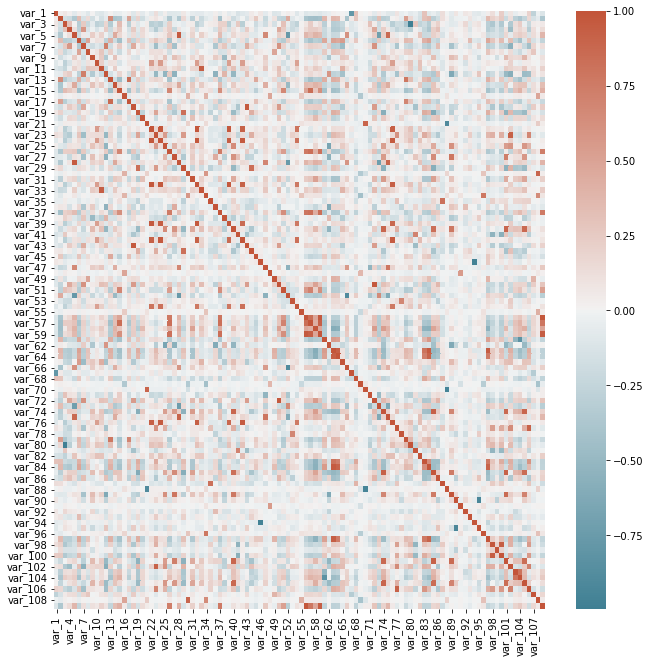

In [6]:
# visualise correlated features:

# I will build a correlation matrix, which examines the 
# correlation of all features (that is, for all possible feature combinations)
# and then visualise the correlation matrix using a heatmap

# the default correlation method of pandas.corr is pearson
# I include it anyways for the demo
corrmat = X_train.corr(method='pearson')

# we can make a heatmap with the package seaborn
# and customise the colours of searborn's heatmap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# some more parameters for the figure
fig, ax = plt.subplots()
fig.set_size_inches(11,11)

# and now plot the correlation matrix
sns.heatmap(corrmat, cmap=cmap)

In the plot above, the dark orange squares correspond to highly correlated features (>0.8). Darker blue squares corresponds to negatively correlated features (<-0.8).

The diagonal represents the correlation of a feature with itself, therefore the value is 1.

We can see that there are a few features that are highly correlated.

## Correlation scatterplots

In [7]:
# Looking at the heatmap, we see that var25 is highly correlated 
# with others in the dataset

# with this code we can get the other variable names
# and also print the correlation coefficient between var25 and 
# these variables:

c = 0

# iterate over each correlation value for var_5:
for i in corrmat.loc['var_5']:
    
    # if highly correlated
    if i>0.8:
        
        # print the variable name and the correlation coefficient
        print(corrmat.columns[c], i)
        
    c = c +1

var_5 1.0
var_28 0.9536721652385074
var_75 0.8616179292025175


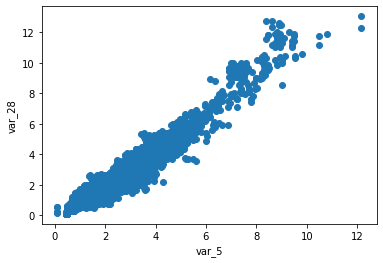

In [8]:
# now, let's plot the variables

plt.scatter(X_train['var_5'], X_train['var_28'])
plt.ylabel('var_28')
plt.xlabel('var_5')
plt.show()

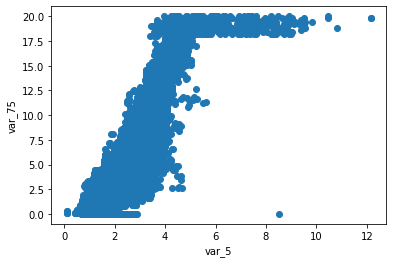

In [9]:
# now, let's plot the variables

plt.scatter(X_train['var_5'], X_train['var_75'])
plt.ylabel('var_75')
plt.xlabel('var_5')
plt.show()

We see that the correlation of the second pair of variables is not quite linear.

Next, let's identify a couple of negatively correlated variables:

In [10]:
c = 0
for i in corrmat.loc['var_88']:
    
    # if highly and negatively correlated
    if i<-0.8:
        
        # print the variable name and the correlation coefficient
        print(corrmat.columns[c], i)
        
    c = c +1

var_21 -0.8943929785046749
var_70 -0.9489465365954275


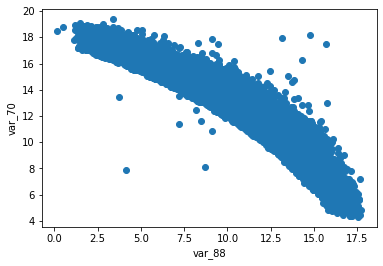

In [11]:
# now, let's plot the variables

plt.scatter(X_train['var_88'], X_train['var_70'])
plt.ylabel('var_70')
plt.xlabel('var_88')
plt.show()

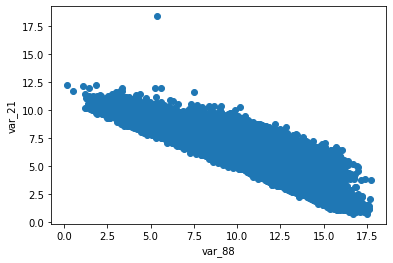

In [12]:
plt.scatter(X_train['var_88'], X_train['var_21'])
plt.ylabel('var_21')
plt.xlabel('var_88')
plt.show()

The higher the value of 1 variable, the lower the value of the other variable.

Now let's proceed with feature selection

## Remove correlated

### Brute force approach

In [13]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything else
# without any further insight.

def correlation(dataset, threshold):
    
    # create a set where I will store the names of correlated columns
    col_corr = set()
    
    # create the correlation matrix
    corr_matrix = dataset.corr()
    
    # for each feature in the dataset (columns of the correlation matrix)
    for i in range(len(corr_matrix.columns)):
        
        # check with other features
        for j in range(i):
            
            # if the correlation is higher than a certain threshold
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                
                # print correlation, and variables examined
                # keep in mind that the columns and rows of the dataframe are identical
                # so we can identify the features being examned by looking for i,j
                # in the column names
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                
                # get the name of the correlated feature
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

**Note**, if the code in cell 50 is hard to understand, either run the code line by line (you would have to manually enter some of the values of i), or add print statements within the loop to print the intermediate outputs.

In [14]:
corr_features = correlation(X_train, 0.8)
len(set(corr_features))

0.8632980418993852 var_17 var_13
0.9813409653986886 var_24 var_22
0.9536721652385074 var_28 var_5
0.8341792843814487 var_29 var_19
0.9904307349993785 var_32 var_22
0.9804113632495275 var_32 var_24
0.9443605986205716 var_33 var_11
0.9744609333741692 var_39 var_22
0.943115386679052 var_39 var_24
0.9748779191363351 var_39 var_32
0.9191057911749927 var_42 var_22
0.9672922649953323 var_42 var_24
0.9199183443060889 var_42 var_32
0.8567453370819024 var_42 var_39
0.9654741987814612 var_43 var_18
0.8358214281472603 var_44 var_29
0.8150241475398569 var_54 var_24
0.8287090109274778 var_54 var_42
0.8374044816360672 var_57 var_15
0.8318090759398231 var_57 var_26
0.8207993837973165 var_57 var_37
0.8440857367712463 var_57 var_56
0.813194752522628 var_59 var_26
0.8306144274586847 var_59 var_37
0.9757443944210531 var_59 var_56
0.9223172758595206 var_59 var_57
0.9244600573582376 var_64 var_63
0.8925221926487126 var_66 var_52
0.8953971637379001 var_70 var_21
0.9702627369946087 var_72 var_50
0.88311916559

40

We can see that 40 features are highly correlated with other features in the training set. 

Very likely, by removing these correlated features, the performance of your machine learning models will drop very little, if at all. We can go ahead and drop the features like we have done in previous lectures.



In [15]:
corr_features

{'var_101',
 'var_103',
 'var_11',
 'var_13',
 'var_15',
 'var_18',
 'var_19',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_26',
 'var_28',
 'var_29',
 'var_3',
 'var_30',
 'var_32',
 'var_35',
 'var_37',
 'var_39',
 'var_40',
 'var_42',
 'var_46',
 'var_5',
 'var_50',
 'var_52',
 'var_56',
 'var_57',
 'var_59',
 'var_60',
 'var_63',
 'var_64',
 'var_70',
 'var_74',
 'var_77',
 'var_84',
 'var_85',
 'var_89',
 'var_90',
 'var_98'}

In [16]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 68), (15000, 68))

By removing correlated columns we reduced the feature space from 108 numerical columns to 68.

### Second approach

The second approach looks to identify groups of highly correlated features. And then, we can make further investigation within these groups to decide which feature we keep and which one we remove.

In [17]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

In [18]:
# build a dataframe with the correlation between features
# remember that the absolute value of the correlation
# coefficient is important and not the sign

corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,var_80,var_3,0.994923
1,var_3,var_80,0.994923
2,var_22,var_32,0.990431
3,var_32,var_22,0.990431
4,var_109,var_56,0.987777


**Note**, if the code above is not clear, run each command individually.

In [19]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))

found 26 correlated groups
out of 108 total features


In [20]:
# now we can print out each group. We see that some groups contain
# only 2 correlated features, some other groups present several features 
# that are correlated among themselves.

for group in correlated_groups:
    print(group)
    print()

  feature1 feature2      corr
0   var_80    var_3  0.994923

   feature1 feature2      corr
2    var_22   var_32  0.990431
6    var_22   var_24  0.981341
15   var_22   var_39  0.974461
45   var_22   var_76  0.931911
59   var_22   var_42  0.919106

   feature1 feature2      corr
4   var_109   var_56  0.987777
34  var_109   var_59  0.944842

   feature1 feature2      corr
16   var_72   var_50  0.970263

   feature1 feature2      corr
18   var_46   var_94  0.967895

   feature1 feature2      corr
22   var_18   var_43  0.965474

   feature1 feature2      corr
26   var_63   var_84  0.959138
41   var_63   var_97  0.940184
52   var_63   var_64  0.924460

   feature1 feature2      corr
30    var_5   var_28  0.953672
94    var_5   var_75  0.861618

   feature1 feature2      corr
32   var_70   var_88  0.948947
72   var_70   var_21  0.895397

   feature1 feature2      corr
36   var_33   var_11  0.944361

   feature1 feature2      corr
42  var_100   var_98  0.938629

    feature1 feature2      cor

In [21]:
# we can now investigate further features within one group.
# let's for example select group 1

group = correlated_groups[1]
group

,feature1,feature2,corr
2,var_22,var_32,0.990431
6,var_22,var_24,0.981341
15,var_22,var_39,0.974461
45,var_22,var_76,0.931911
59,var_22,var_42,0.919106


**In this group, several features are highly correlated. Which one should we keep and which ones should we remove?**

One criteria to select which features to use from this group, would be to use those with **less missing data**. 

Our dataset contains no missing values, so this is not an option. But keep this in mind when you work with your own datasets.

Alternatively, we could build a **machine learning algorithm using all the features from the above list, and select the more predictive one**.

In [22]:
from sklearn.ensemble import RandomForestClassifier

# add all features of the group to a list
features = list(group['feature2'].unique())+['var_22']

# train a random forest 
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

RandomForestClassifier(max_depth=4, n_estimators=200, random_state=39)

In [23]:
# get the feature importance attributed by the 
# random forest model (more on this in coming lectures)

importance = pd.concat(
    [pd.Series(features),
     pd.Series(rf.feature_importances_)], axis=1)

importance.columns = ['feature', 'importance']

# sort features by importance, most important first
importance.sort_values(by='importance', ascending=False)

,feature,importance
2,var_39,0.193758
3,var_76,0.181767
5,var_22,0.177793
4,var_42,0.154643
1,var_24,0.152343
0,var_32,0.139697


In this case, feature var_39 shows the highest importance according to random forests. Then, I would select var_39, and remove all the remaining features from this group from the dataset.

**Note**

None of the 2 procedures for removing correlated features are perfect, and some correlated features may escape the loops of code. So it might be worthwhile checking that after removing the correlated features, there are no correlated features left in the dataset. If there are, repeat the procedure to remove the remaining ones.

That is all for this lecture, I hope you enjoyed it and see you in the next one!

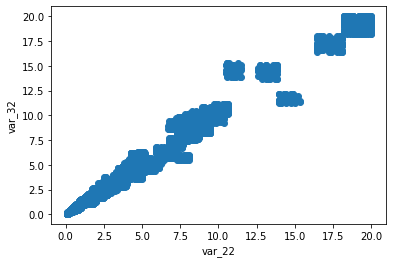

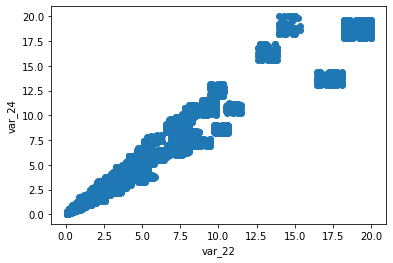

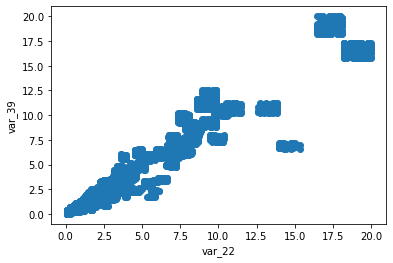

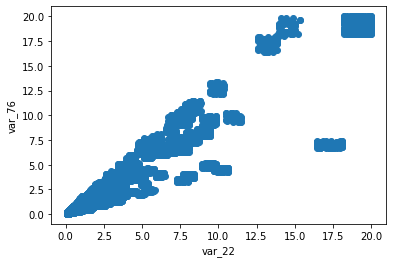

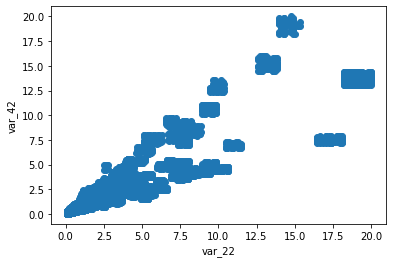

In [24]:
# BONUS:
# let's plot the correlation of the features in the correlated group from the
# previous cell

for feature in group['feature2']:
    plt.scatter(X_train['var_22'], X_train[feature])
    plt.xlabel('var_22')
    plt.ylabel(feature)
    plt.show()